# Analyse data

In [153]:
import pandas as pd
import json
from pathlib import Path
import utils
import datetime
import numpy as np
import matplotlib 

In [166]:
df_votum_raw = pd.read_csv(Path('../export/votum.csv'))

# Remove non members (mostly former members who are now in the Regierungsrat)
df_votum_raw = df_votum_raw[df_votum_raw.ismember == True]

# Typecast
df_votum_raw['sitzung_date'] = pd.to_datetime(df_votum_raw['sitzung_date'])

# Remove empty texts
df_votum_raw = df_votum_raw[df_votum_raw.text.notna()]

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_votum_raw['year'] = df_votum_raw['sitzung_date'].dt.year
df_votum_raw['month'] = df_votum_raw['sitzung_date'].dt.month
df_votum_raw['session'] = df_votum_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

## How many times did m/w talk?

In [167]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum_pivot = pd.pivot_table(df_votum, index='session', columns='geschlecht', values='name', aggfunc='count').reset_index()

<AxesSubplot:xlabel='session'>

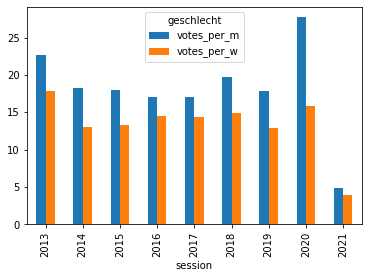

In [169]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df_rat = pd.pivot_table(df, index='year', columns='geschlecht', values='name', aggfunc='count').reset_index()

# Concat
df_res = df_votum_pivot.merge(df_rat, left_on = 'session', right_on = 'year', suffixes=('_v', '_r'))

# Votes per w/m
df_res['votes_per_m'] = round(df_res['m_v'] / df_res['m_r'], 1)
df_res['votes_per_w'] = round(df_res['w_v'] / df_res['w_r'], 1)

df_res.set_index('session', inplace=True)

df_res.drop(columns=['year'], inplace=True)

df_res[['votes_per_m', 'votes_per_w']].plot.bar()

## Unterschiedliche Textlänge?
Erkenntnis: Frauen und Männer reden gleich lange. Wohl wegen beschränkter Redezeit?

In [170]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.reset_index(drop=True)

# Count words
#df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x.split()))
df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x))

df_votum = df_votum.groupby('geschlecht').agg({
    'wordcount': 'sum',
    'name': 'count'
})

df_votum['l'] = round(df_votum['wordcount'] / df_votum['name'])

df_votum

,wordcount,name,l
geschlecht,,,
m,37385292,19651,1902.0
w,14783401,7725,1914.0


## The Speakers...

<AxesSubplot:ylabel='name'>

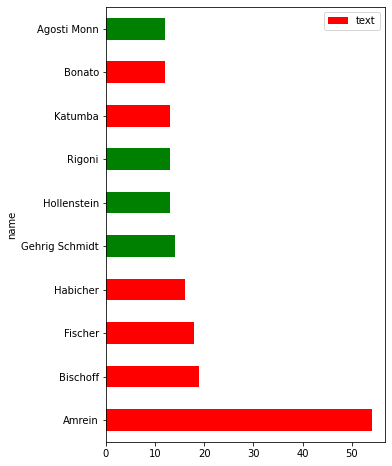

In [171]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session == 2021]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum = df_votum.head(10)

c = list(df_votum['geschlecht'].apply(lambda x: 'red' if x == 'm' else 'green'))
df_votum.plot(kind='barh', x='name', y='text', color=c, figsize=(5, 8))

#df_votum.head()

## Talking parties...

<AxesSubplot:xlabel='partei'>

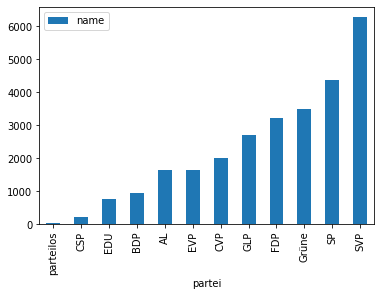

In [183]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).sort_values('name')
df_votum.plot.bar()

<AxesSubplot:>

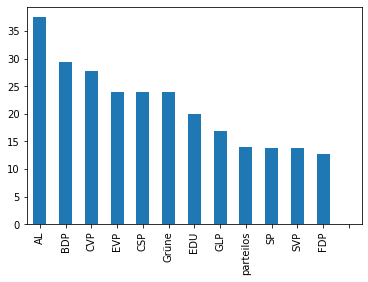

In [220]:
# Relative per strength
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df = pd.pivot_table(df, columns='party', values='name', aggfunc='count').reset_index(drop=True)
df.loc[0, 'name'] = 'members'

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).T.reset_index(drop=True)
df_votum.loc[0, 'name'] = 'votes'

# Combine both datasets, set index and transform
df = pd.concat([df, df_votum])
df = df.set_index('name').T
df = df.fillna(0)

# Calculate Vote per Member
df['per_member'] = round(df['votes'] / df['members'], 1)

df.sort_values('per_member', ascending=False)['per_member'].plot.bar()

In [221]:
df.sort_values('per_member', ascending=False)

name,members,votes,per_member
AL,44.0,1651.0,37.5
BDP,32.0,938.0,29.3
CVP,73.0,2022.0,27.7
EVP,69.0,1657.0,24.0
CSP,9.0,215.0,23.9
Grüne,146.0,3487.0,23.9
EDU,39.0,778.0,19.9
GLP,161.0,2718.0,16.9
parteilos,2.0,28.0,14.0
SP,316.0,4380.0,13.9
